# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:22<00:00, 2092.14it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [25]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
#final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (46071, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 39364)
the number of unique words  39364


## [4.2] Bi-Grams and n-Grams.

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8417444229125977), ('good', 0.8040033578872681), ('fantastic', 0.8023741245269775), ('terrific', 0.800918698310852), ('excellent', 0.7766530513763428), ('wonderful', 0.7651624083518982), ('amazing', 0.755885899066925), ('perfect', 0.7346857786178589), ('decent', 0.6903915405273438), ('nice', 0.6657285690307617)]
[('best', 0.7411230206489563), ('greatest', 0.700343132019043), ('nastiest', 0.6882908344268799), ('tastiest', 0.6632184982299805), ('closest', 0.644715428352356), ('awful', 0.6407889127731323), ('experienced', 0.6361461877822876), ('horrible', 0.6198444366455078), ('disgusting', 0.6195648908615112), ('eaten', 0.6139364242553711)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46071/46071 [01:57<00:00, 390.66it/s]


46071
50


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 46071/46071 [42:40<00:00, 17.99it/s]  


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [36]:
X=final['CleanedText'].values
Y=final['Score'].values

In [37]:
#splitting data randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)


(20680,) (20680,)
(10187,) (10187,)
(15204,) (15204,)


In [38]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(20680, 27199) (20680,)
(10187, 27199) (10187,)
(15204, 27199) (15204,)


In [39]:
#K fold cross validation
myList=np.arange(3,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn, X_train_bow,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())


In [40]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 45.


In [41]:
knn_optimal = KNeighborsClassifier(n_neighbors = 45,algorithm = 'brute')
knn_optimal.fit(X_train_bow,Y_train)
pred = knn_optimal.predict(X_test_bow)

In [42]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_bow)[:,1]))

0.7734479818083704


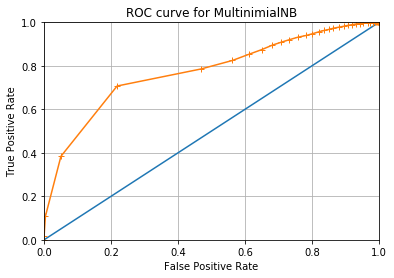

In [43]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_bow)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

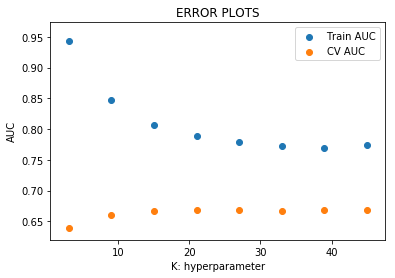

In [44]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))


plt.scatter(K, train_auc, label='Train AUC')

plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

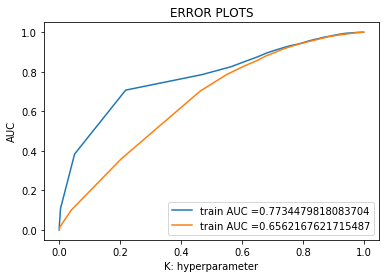

In [45]:

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

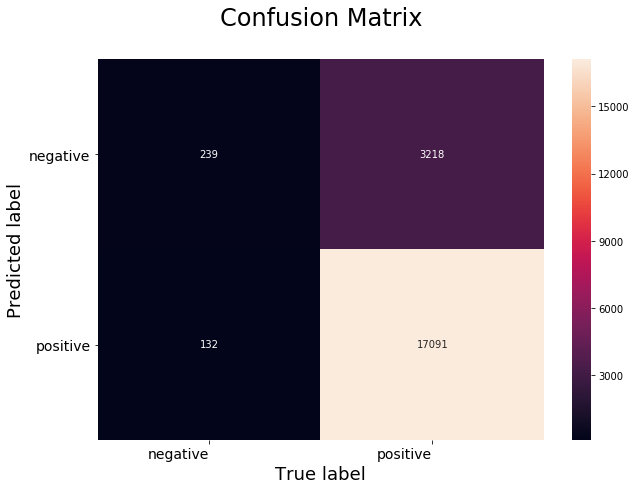

In [46]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()


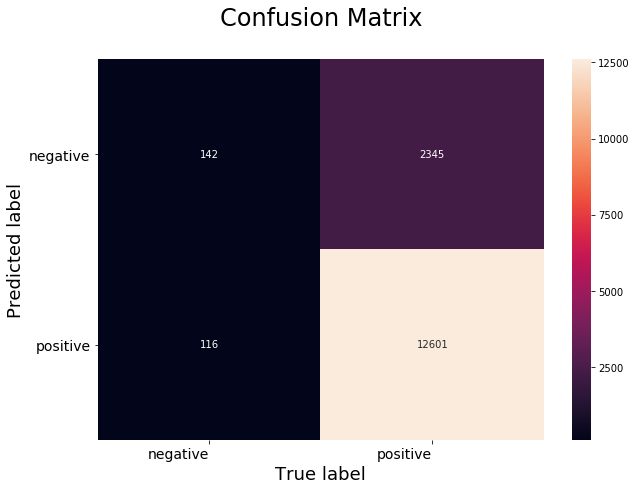

In [47]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()



In [48]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.55      0.06      0.10      2487
           1       0.84      0.99      0.91     12717

    accuracy                           0.84     15204
   macro avg       0.70      0.52      0.51     15204
weighted avg       0.80      0.84      0.78     15204



### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [57]:
X=final['CleanedText'].values
Y=final['Score'].values

In [58]:
#splitting data randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.30) # this is random splitting

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)


(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer =TfidfVectorizer()

tfidf_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_cv_tfidf = tfidf_vectorizer.transform(X_cv)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, Y_train.shape)
print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(22574, 28176) (22574,)
(9675, 28176) (9675,)
(13822, 28176) (13822,)


In [60]:
#K fold cross validation
myList=np.arange(1,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn, X_train_tfidf,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [61]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 49.


In [63]:
knn_optimal = KNeighborsClassifier(n_neighbors = 45,algorithm = 'brute')
knn_optimal.fit(X_train_tfidf,Y_train)
pred = knn_optimal.predict(X_test_tfidf)

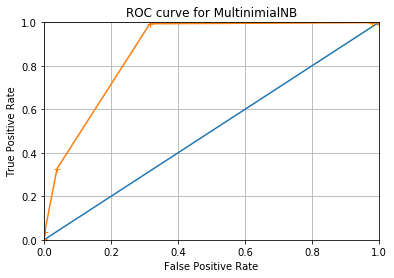

In [64]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_tfidf)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

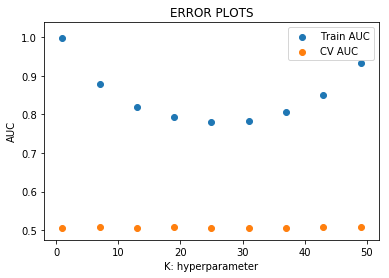

In [65]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.scatter(K, train_auc, label='Train AUC')

plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

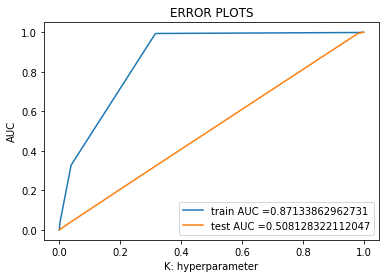

In [66]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

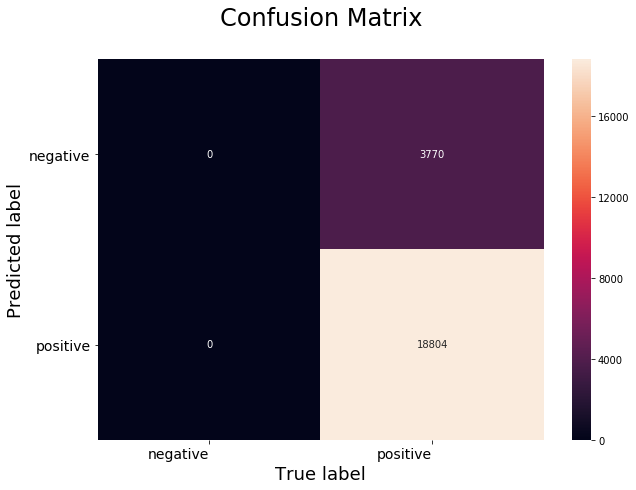

In [67]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

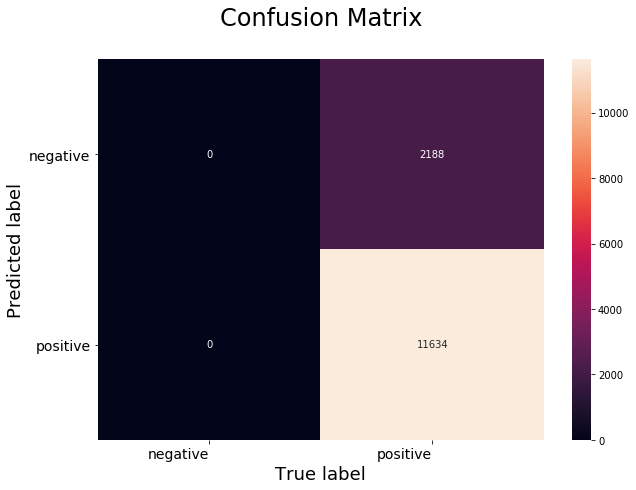

In [68]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [69]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2188
           1       0.84      1.00      0.91     11634

    accuracy                           0.84     13822
   macro avg       0.42      0.50      0.46     13822
weighted avg       0.71      0.84      0.77     13822



### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [70]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [71]:
#Please write all the code with proper documentation
#word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 22574/22574 [00:47<00:00, 480.28it/s]


22574
50


100%|██████████| 9675/9675 [00:19<00:00, 498.67it/s]


9675
50


100%|██████████| 13822/13822 [00:28<00:00, 482.46it/s]


13822
50


In [72]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

In [73]:
#K fold cross validation
myList=np.arange(1,51,2)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn, X_train_w2v,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [74]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 45.


In [75]:
from sklearn.metrics import accuracy_score
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'brute')
knn_optimal.fit(X_train_w2v,Y_train)
pred = knn_optimal.predict(X_test_w2v)


In [76]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_w2v)[:,1]))

0.8902505521795568


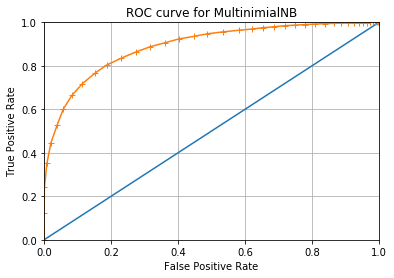

In [77]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_w2v)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

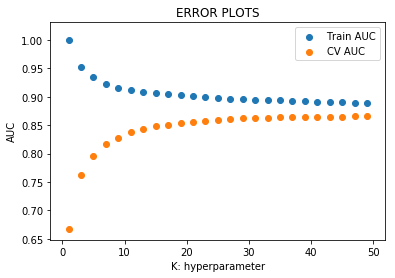

In [78]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(X_train_w2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_w2v)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.scatter(K, train_auc, label='Train AUC')

plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

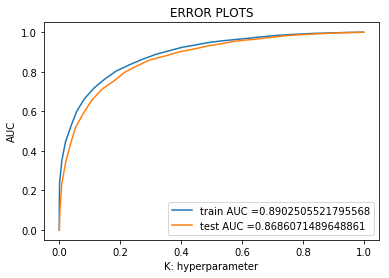

In [79]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

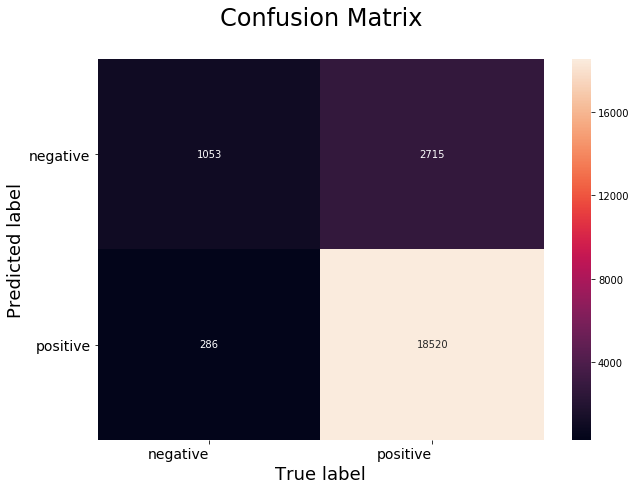

In [80]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

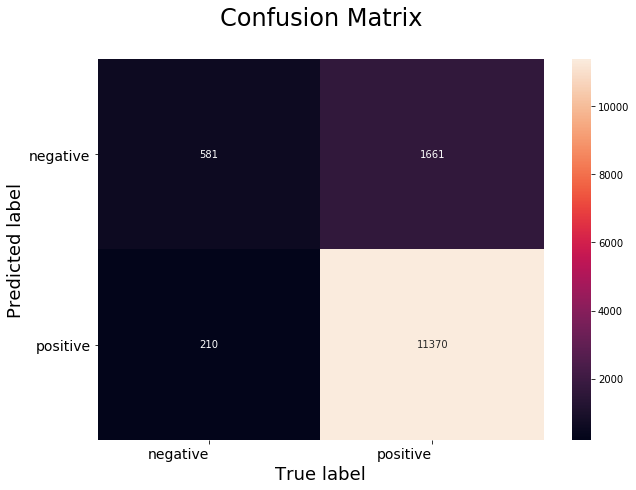

In [81]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [82]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [83]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#for cross validation data and test we will use same words and models of train

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#for test data

list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|██████████| 13822/13822 [00:44<00:00, 313.59it/s]


In [84]:
X_train_tfw2v=tfidf_sent_vectors_train
X_cv_tfw2v=tfidf_sent_vectors_cv
X_test_tfw2v=tfidf_sent_vectors_test


In [86]:
#K fold cross validation
myList=np.arange(1,51,2)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation


for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
    scores=cross_val_score(knn, X_train_tfw2v,Y_train,cv=10,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [88]:
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 47.


In [89]:
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'brute')
knn_optimal.fit(X_train_tfw2v,Y_train)
pred = knn_optimal.predict(X_test_tfw2v)

In [90]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_tfw2v)[:,1]))

0.8433091337474381


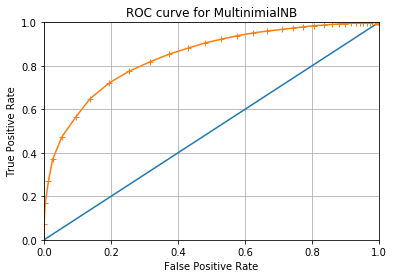

In [91]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_tfw2v)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


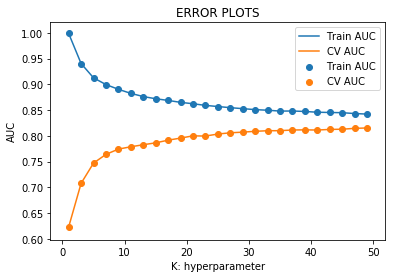

In [93]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn.fit(X_train_tfw2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tfw2v)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tfw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

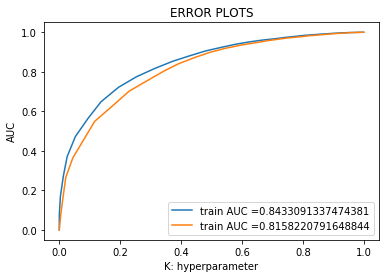

In [94]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_tfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

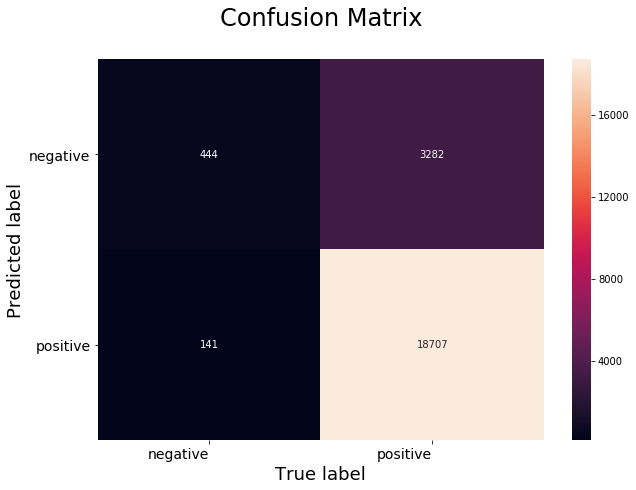

In [95]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

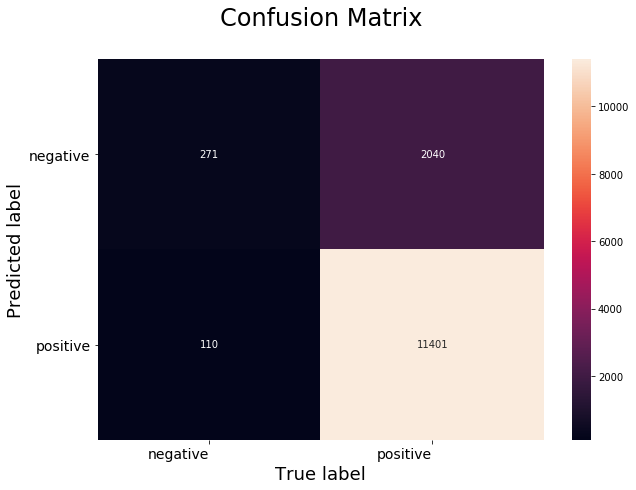

In [96]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [97]:
#splitting data randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33) # this is random splitting

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(20680,) (20680,)
(10187,) (10187,)
(15204,) (15204,)


In [98]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_bow= svd.fit_transform(X_train_bow)
X_test_bow = svd.transform(X_test_bow)
X_cv_bow = svd.transform(X_cv_bow)


print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(20680, 100) (20680,)
(10187, 100) (10187,)
(15204, 100) (15204,)


In [102]:
#K fold cross validation
myList=np.arange(1,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation



for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores=cross_val_score(knn, X_train_bow,Y_train,cv=3,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [103]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 43.


In [104]:

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'kd_tree')
knn_optimal.fit(X_train_bow,Y_train)
pred = knn_optimal.predict(X_test_bow)


In [105]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_bow)[:,1]))

0.8176373296396694


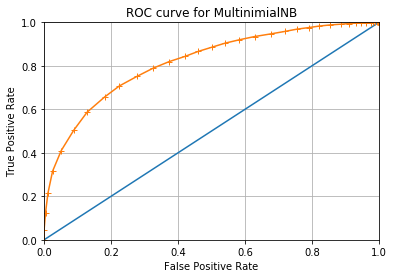

In [106]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_bow)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


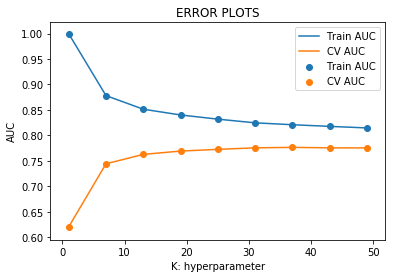

In [107]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_bow)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

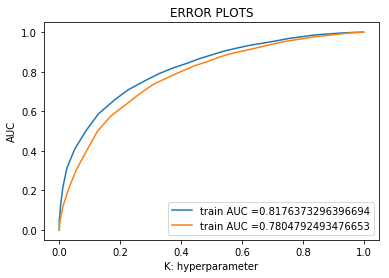

In [108]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

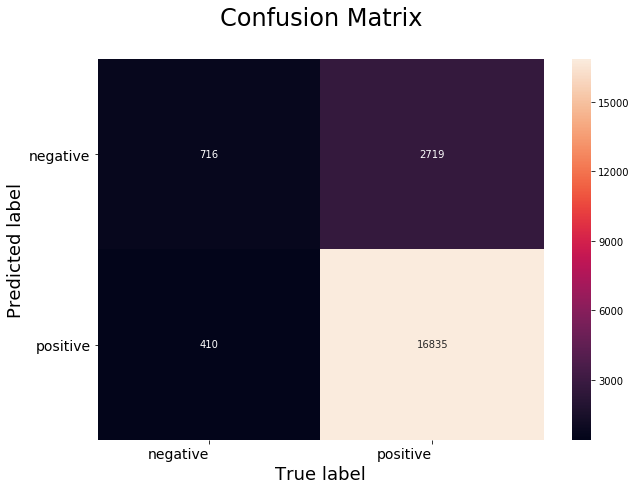

In [109]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

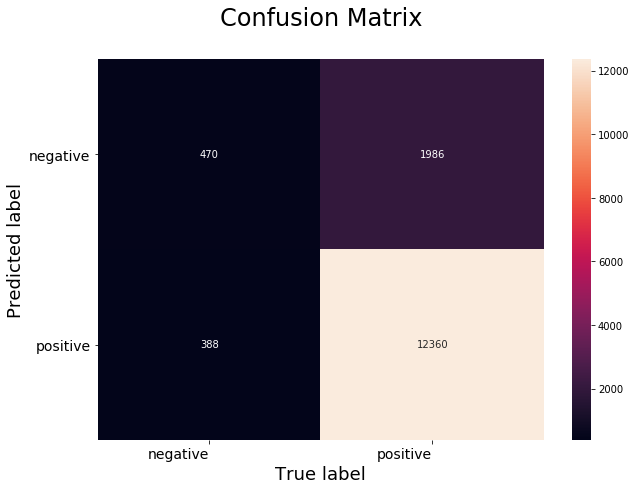

In [110]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_bow)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [111]:
#splitting data randomly
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.30) # this is random splitting

print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer =TfidfVectorizer()

tfidf_vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_cv_tfidf = tfidf_vectorizer.transform(X_cv)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_tfidf= svd.fit_transform(X_train_tfidf)
X_test_tfidf = svd.transform(X_test_tfidf)
X_cv_tfidf = svd.transform(X_cv_tfidf)

print("After vectorizations")
print(X_train_tfidf.shape, Y_train.shape)
print(X_cv_tfidf.shape, Y_cv.shape)
print(X_test_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(22574, 100) (22574,)
(9675, 100) (9675,)
(13822, 100) (13822,)


In [115]:
#K fold cross validation
myList=np.arange(1,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation



for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores=cross_val_score(knn, X_train_tfidf,Y_train,cv=3,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [116]:
# determining best k
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 31.


In [117]:

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'brute')
knn_optimal.fit(X_train_tfidf,Y_train)
pred = knn_optimal.predict(X_test_tfidf)


In [118]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_tfidf)[:,1]))

0.8466631819135628


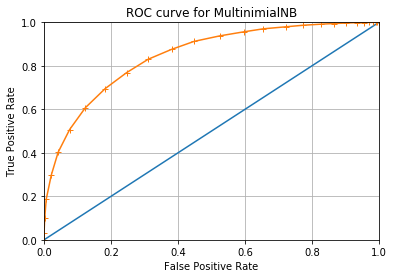

In [119]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_tfidf)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

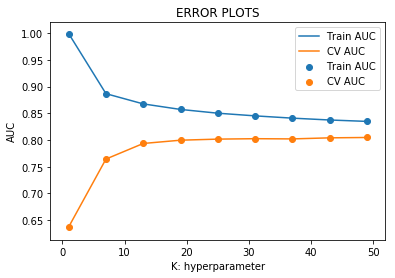

In [120]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

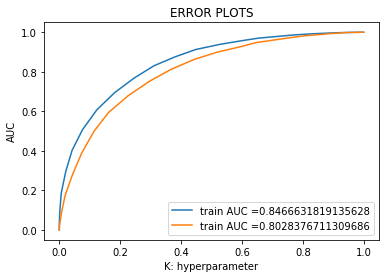

In [121]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

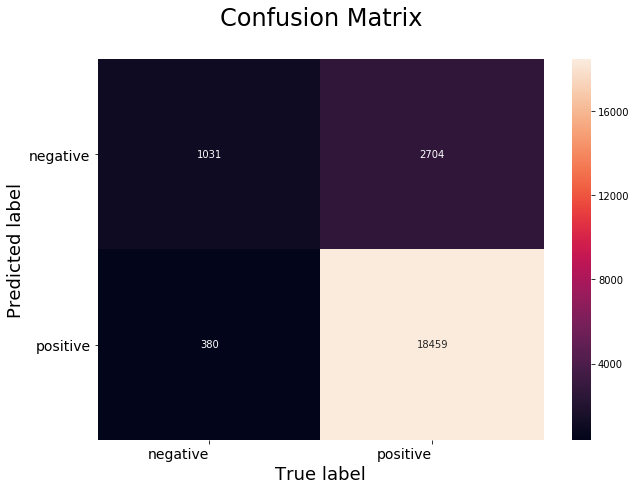

In [122]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

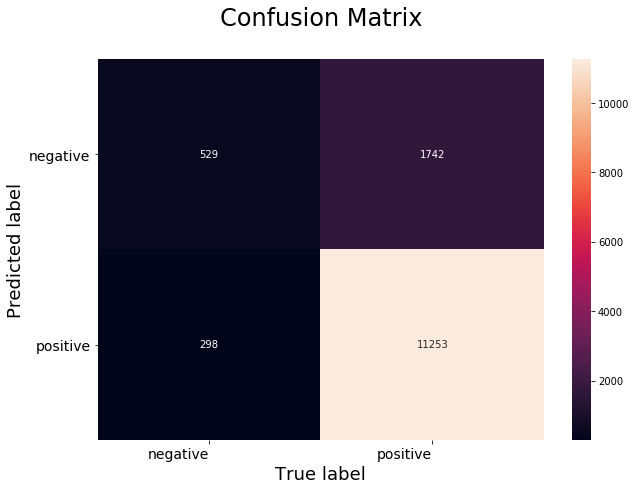

In [123]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_tfidf)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [124]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [125]:
#Please write all the code with proper documentation
#word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 22574/22574 [00:40<00:00, 562.80it/s]


22574
50


100%|██████████| 9675/9675 [00:14<00:00, 647.24it/s]


9675
50


100%|██████████| 13822/13822 [00:21<00:00, 631.12it/s]


13822
50


In [126]:
X_train_w2v=sent_vectors_train
X_cv_w2v=sent_vectors_cv
X_test_w2v=sent_vectors_test

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=49)
X_train_w2v= svd.fit_transform(X_train_w2v)
X_test_w2v = svd.transform(X_test_w2v)
X_cv_w2v = svd.transform(X_cv_w2v)

In [127]:
#K fold cross validation
myList=np.arange(1,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation


for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores=cross_val_score(knn, X_train_w2v,Y_train,cv=3,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [128]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 49.


In [129]:
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'kd_tree')
knn_optimal.fit(X_train_w2v,Y_train)
pred = knn_optimal.predict(X_test_w2v)


In [130]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_w2v)[:,1]))

0.8823250663942926


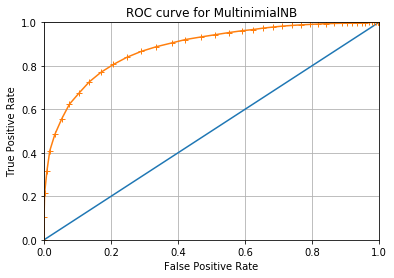

In [131]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_w2v)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

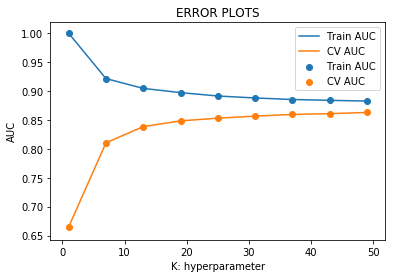

In [132]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(X_train_w2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_w2v)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_w2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

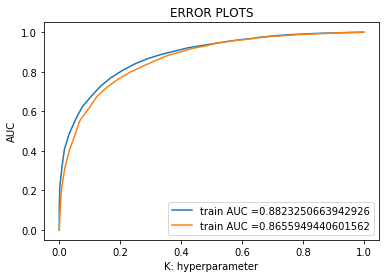

In [133]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_w2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_w2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

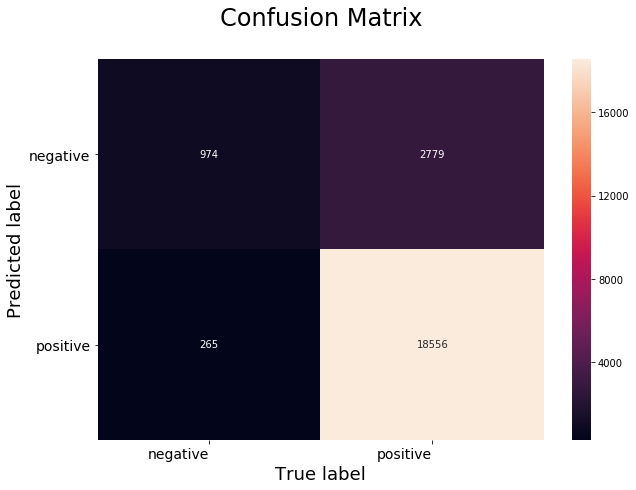

In [134]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

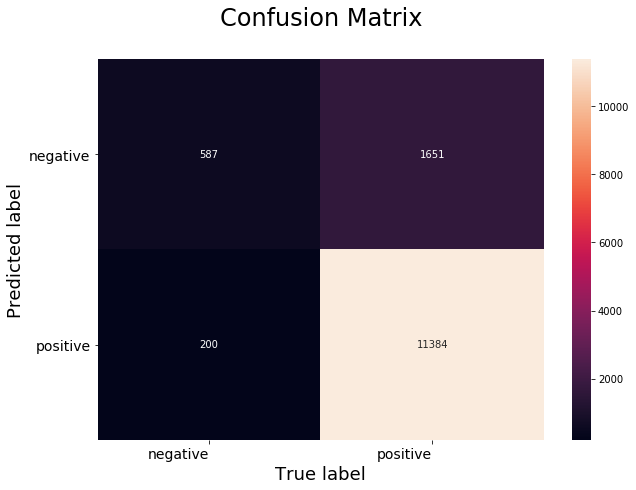

In [135]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_w2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [136]:
#Splitting data randomly
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.30)
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.30)

print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(22574,) (22574,)
(9675,) (9675,)
(13822,) (13822,)


In [137]:
# Please write all the code with proper documentation
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_matrix=tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#for cross validation data and test we will use same words and models of train

list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#for test data

list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [00:35<00:00, 390.63it/s]


In [138]:
X_train_tfw2v=tfidf_sent_vectors_train
X_cv_tfw2v=tfidf_sent_vectors_cv
X_test_tfw2v=tfidf_sent_vectors_test


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=49)
X_train_tfw2v= svd.fit_transform(X_train_tfw2v)
X_test_tfw2v = svd.transform(X_test_tfw2v)
X_cv_tfw2v = svd.transform(X_cv_tfw2v)

In [139]:
#K fold cross validation
myList=np.arange(1,51,3)  # odd list of k for KNN
neighbors=list(filter(lambda x: x%2 !=0,myList))

cv_scores=[] #Empty list that will hold cv_scores

#10 fold crosss validation



for k in neighbors:
    knn=KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores=cross_val_score(knn, X_train_tfw2v,Y_train,cv=3,scoring='roc_auc')
    cv_scores.append(scores.mean())

In [140]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 49.


In [141]:

knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k,algorithm = 'kd_tree')
knn_optimal.fit(X_train_tfw2v,Y_train)
pred = knn_optimal.predict(X_test_tfw2v)


In [142]:
print(metrics.roc_auc_score(Y_train,knn_optimal.predict_proba(X_train_tfw2v)[:,1]))

0.8500062031768988


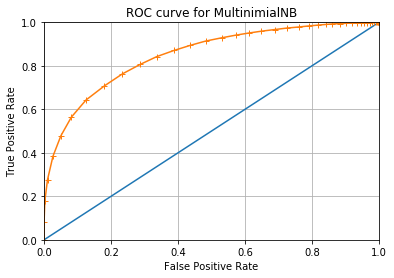

In [143]:
# IMPORTANT: first argument is true values,second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_train,knn_optimal.predict_proba(X_train_tfw2v)[:,1])
plt.plot([0, 1], [0, 1], linestyle='-')
plt.plot(fpr, tpr, marker='+')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for MultinimialNB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

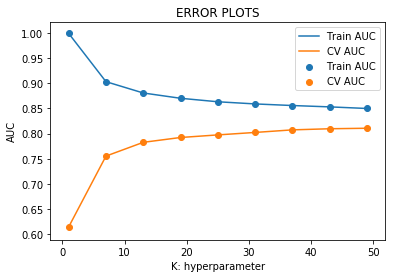

In [144]:
from sklearn.metrics import roc_curve,roc_auc_score

train_auc = []
cv_auc = []
K = neighbors
for i in K:
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
    knn.fit(X_train_tfw2v, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred =  knn.predict_proba(X_train_tfw2v)[:,1]
    Y_cv_pred =  knn.predict_proba(X_cv_tfw2v)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))

plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

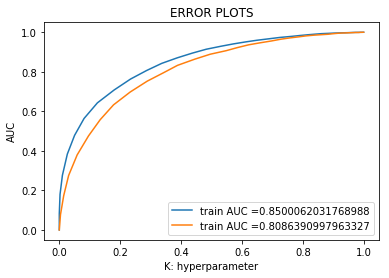

In [145]:
#ROC AUC curve on train and test data

from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn_optimal.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn_optimal.predict_proba(X_test_tfw2v)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

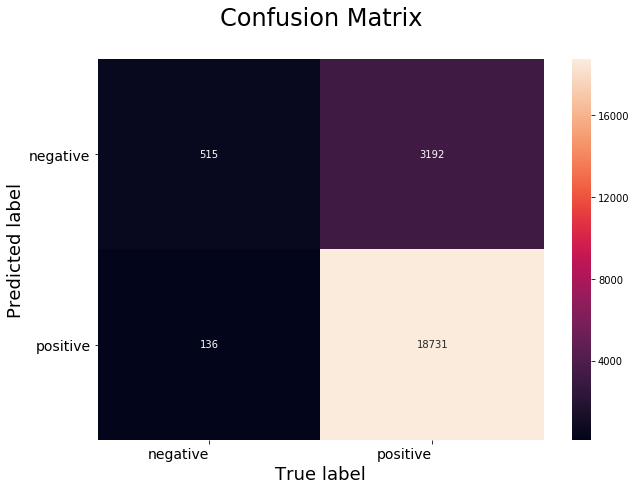

In [146]:
#Draw seaborn heat map for representaion of confusion matrix train data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_train,knn_optimal.predict(X_train_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

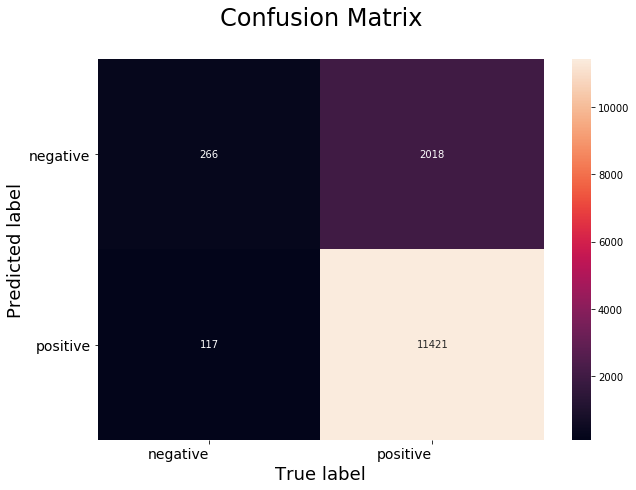

In [147]:
#Draw seaborn heat map for representaion of confusion matrix for test data

from sklearn.metrics import confusion_matrix


class_names=['negative','positive']
df_heatmap=pd.DataFrame(confusion_matrix(Y_test,knn_optimal.predict(X_test_tfw2v)),index=class_names,columns=class_names)
fig=plt.figure(figsize=(10,7))
heatmap=sns.heatmap(df_heatmap,annot=True,fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable
names=["brute_BOW","brute_TF_IDF","brute_w2v","brute_tfw2v","kd_bow","kd_tfidf","kd_w2v","kd_tfw2v"]

optimal_k = []


train_acc=[]


test_acc=[]



index = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("Index.",index)
ptable.add_column("Model",names)
ptable.add_column("Best_K",optimal_k)
ptable.add_column("Training_Accuracy",train_acc)
ptable.add_column("Test_Accuracy",test_acc)

print(ptable)